# IMAGE CLASSIFICATION FOR AMERICAN SIGN LANGUAGE (ASL)

This project is to classified each ASL sign language with it's respective classes. There are 24 classes excluding J and Z as they are motion gesture. In this project, we are going to use our own set of captured data and train our own model to detect ASL sign language. 

# LIBRARY

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2
import pandas as pd
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop

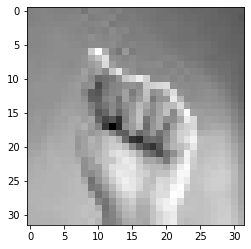

In [2]:
#file directory to training folder
data_dir = "./handgestures/train"

#number of classes = 24 not included j and z as they are motion gesture
CATAGORIES = ['A', 'B' ,'C' ,'D' ,'E' ,'F' ,'G' ,'H' ,'I' ,'K' ,'L' ,'M' ,'N' ,'O' ,'P' ,'Q' ,'R' ,'S' ,'T' ,'U' ,'V' ,'W' ,'X' ,'Y']


for category in CATAGORIES:
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap="gray")
        plt.show()
        break
    break

In [3]:
#printing img array
print(img_array.shape)

(32, 32)


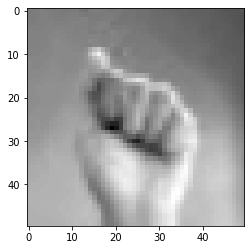

In [4]:
#changing image array
IMG_SIZE = 50

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap = 'gray')
plt.show()

# CREATE DATASET

In [5]:
batch_size = 32 #Number of training examples utilized in one iteration
img_height = 32 #height of image
img_width = 32 #width of image

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=841, #initilization state of a pseudo random number generator
    image_size=(img_height, img_width),
    batch_size = batch_size
)

Found 8400 files belonging to 24 classes.
Using 6720 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split =0.2,
    subset="validation",
    seed=841, #initilization state of a pseudo random number generator
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 8400 files belonging to 24 classes.
Using 1680 files for validation.


In [8]:
class_name = train_ds.class_names
print(class_name)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


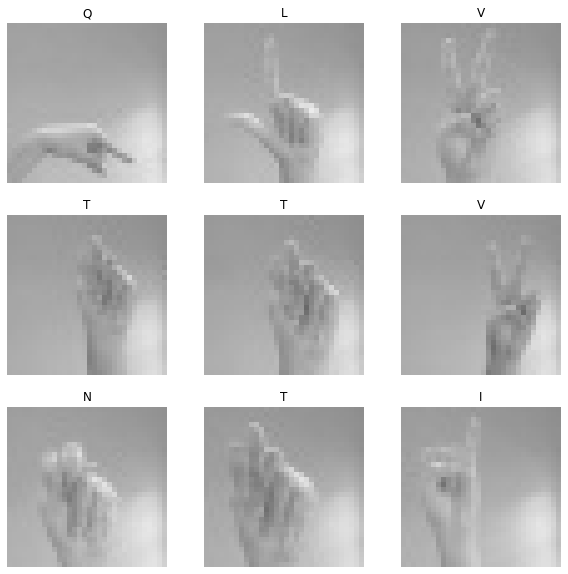

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_name[labels[i]])
    plt.axis('off')

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 32, 32, 3)
(32,)


In [11]:
#AUTOTUNE is to make TensorFlow choose the right number of threads dynamically based on the available CPU.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
#Layer normalization normalizes input across the features instead of normalizing input features across the batch dimension in batch normalization.
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y : (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.46274513 0.90196085


# CREATE MODEL & COMPILE THE MODEL

In [107]:
num_classes = 24

def create_model():
    model = Sequential([
                
                    #1st conv block
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    layers.Conv2D(32, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),

                    #2nd conv block
                    layers.Conv2D(64, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),

                    #3rd conv block
                    layers.Conv2D(128, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(2,1),
                    
                    #4th conv block
                    layers.Conv2D(256, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(2,1),
                    
                    layers.Flatten(),
                    layers.Dense(256, activation='relu'),
                    layers.Dense(num_classes)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

model = create_model()
model.summary

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000012ED4C59E80>>

# COMPILE THE MODEL

In [108]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [109]:
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_35 (Rescaling)     (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_135 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_136 (MaxPoolin (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_137 (MaxPoolin (None, 7, 7, 128)       

# TRAIN THE MODEL

In [110]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1)

model = create_model()

epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks = [cp_callback],
    epochs=epochs)

Epoch 1/10
210/210 [==============================] - 14s 66ms/step - loss: 3.0489 - accuracy: 0.0808 - val_loss: 2.1552 - val_accuracy: 0.3321

Epoch 00001: saving model to training_1\cp.ckpt
Epoch 2/10
210/210 [==============================] - 15s 72ms/step - loss: 1.4418 - accuracy: 0.5379 - val_loss: 0.8078 - val_accuracy: 0.7226

Epoch 00002: saving model to training_1\cp.ckpt
Epoch 3/10
210/210 [==============================] - 14s 68ms/step - loss: 0.5673 - accuracy: 0.8210 - val_loss: 0.3551 - val_accuracy: 0.8893

Epoch 00003: saving model to training_1\cp.ckpt
Epoch 4/10
210/210 [==============================] - 13s 63ms/step - loss: 0.2831 - accuracy: 0.9161 - val_loss: 0.2262 - val_accuracy: 0.9268

Epoch 00004: saving model to training_1\cp.ckpt
Epoch 5/10
210/210 [==============================] - 13s 61ms/step - loss: 0.1544 - accuracy: 0.9534 - val_loss: 0.1915 - val_accuracy: 0.9333

Epoch 00005: saving model to training_1\cp.ckpt
Epoch 6/10
210/210 [===============

In [111]:
!ls {checkpoint_dir}

checkpoint
cp.ckpt.data-00000-of-00001
cp.ckpt.index


# VISUALIZE TRAINING RESULTS

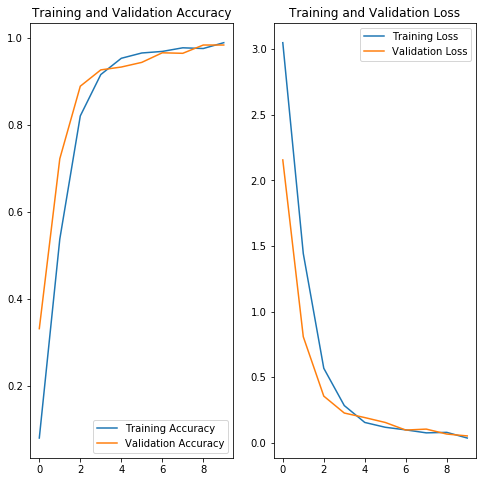

In [112]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# TESTING FOR 1ST TRAINING

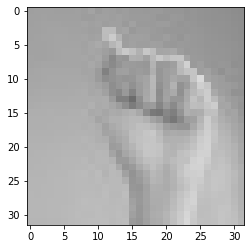

This image most likely belongs to A with a 99.96 percent confidence.


In [117]:
#testing

testing_url = "https://drive.google.com/file/d/1IO_wBmp2Z7ebD76k32_e81I6BmsEXylb/view?usp=sharing"
testing_path ='./handgestures/test/A/75A.jpg'


img = keras.preprocessing.image.load_img(
    testing_path, target_size=(img_width, img_height)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

plt.imshow(img)
plt.show()

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_name[np.argmax(score)], 100 * np.max(score))
)


# DROPOUT

#### This section is used when there is an overfitting data.

In [118]:
def create_model2():
    model = Sequential([
                    
        layers.experimental.preprocessing.Rescaling(1./255),

        #1st conv block
        layers.Conv2D(32, (3), padding='same', activation='relu'),
        layers.MaxPooling2D(),

        #2nd conv block
        layers.Conv2D(64, (3), padding='same', activation='relu'),
        layers.MaxPooling2D(),

        #3rd conv block
        layers.Conv2D(128, (3), padding='same', activation='relu'),
        layers.MaxPooling2D(2,1),
        
        #4th conv block
        layers.Conv2D(256, (3), padding='same', activation='relu'),
        layers.MaxPooling2D(2,1),
        
        #ANN Block
        layers.Flatten(input_shape=[32, 32]),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5), 
        #Incase there is an overfit data during the first training, remove # and apply dropout.
        #This will 

        #output layer
        layers.Dense(25, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])
    
    return model

model = create_model()
model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_37 (Rescaling)     (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_143 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_144 (MaxPoolin (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_145 (MaxPoolin (None, 7, 7, 128)       

In [119]:
model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

In [120]:
model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_37 (Rescaling)     (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_143 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_144 (MaxPoolin (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_145 (MaxPoolin (None, 7, 7, 128)       

#### 2nd Training after applying Dropout

In [121]:
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1)

model = create_model2()

epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks = [cp_callback],
    epochs=epochs)

Epoch 1/10
210/210 [==============================] - 15s 71ms/step - loss: 3.2077 - accuracy: 0.0429 - val_loss: 3.1870 - val_accuracy: 0.0369

Epoch 00001: saving model to training_2\cp.ckpt
Epoch 2/10
210/210 [==============================] - 14s 67ms/step - loss: 3.1915 - accuracy: 0.0427 - val_loss: 3.1802 - val_accuracy: 0.0387

Epoch 00002: saving model to training_2\cp.ckpt
Epoch 3/10
210/210 [==============================] - 13s 61ms/step - loss: 2.9214 - accuracy: 0.1068 - val_loss: 2.2595 - val_accuracy: 0.3208

Epoch 00003: saving model to training_2\cp.ckpt
Epoch 4/10
210/210 [==============================] - 13s 62ms/step - loss: 1.9761 - accuracy: 0.3772 - val_loss: 1.2943 - val_accuracy: 0.6274

Epoch 00004: saving model to training_2\cp.ckpt
Epoch 5/10
210/210 [==============================] - 13s 60ms/step - loss: 1.2890 - accuracy: 0.5692 - val_loss: 0.7245 - val_accuracy: 0.7976

Epoch 00005: saving model to training_2\cp.ckpt
Epoch 6/10
210/210 [===============

# TESTING FOR 2ND TRAINING AFTER DROPOUT

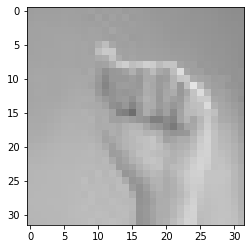

This image most likely belongs to A with a 10.17 percent confidence.


In [122]:
#testing

testing_url = "https://drive.google.com/file/d/1IO_wBmp2Z7ebD76k32_e81I6BmsEXylb/view?usp=sharing"
testing_path ='./handgestures/test/A/150A.jpg'


img = keras.preprocessing.image.load_img(
    testing_path, target_size=(img_width, img_height)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

plt.imshow(img)
plt.show()

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_name[np.argmax(score)], 100 * np.max(score))
)


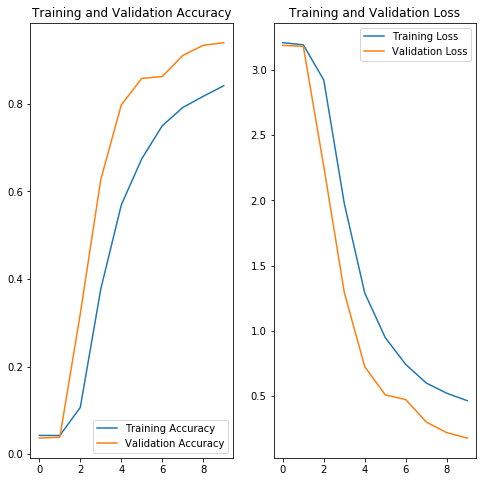

In [123]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# REFERENCE

#### WEBSITE

1. https://www.tensorflow.org/api_docs/python/tf/keras/Model
2. https://keras.io/api/
3. https://deepai.org/machine-learning-glossary-and-terms/sigmoid-function
4. https://towardsdatascience.com/multi-layer-neural-networks-with-sigmoid-function-deep-learning-for-rookies-2-bf464f09eb7f
5. https://towardsdatascience.com/wtf-is-image-classification-8e78a8235acb
6. https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d
7. https://iq.opengenus.org/basics-of-machine-learning-image-classification-techniques/
8. https://www.tensorflow.org/tutorials/images/classification
9. https://www.freecodecamp.org/news/weekend-projects-sign-language-and-static-gesture-recognition-using-scikit-learn-60813d600e79/
10. https://github.com/mon95/Sign-Language-and-Static-gesture-recognition-using-sklearn/blob/master/dataset/pipeline_final.ipynb
11. https://towardsdatascience.com/basics-of-image-classification-with-keras-43779a299c8b
12. https://towardsdatascience.com/build-your-own-convolution-neural-network-in-5-mins-4217c2cf964f

#### YOUTUBE

1. https://youtu.be/j-3vuBynnOE
2. https://youtu.be/WvoLTXIjBYU
3. https://youtu.be/pDXdlXlaCco
4. https://www.youtube.com/watch?v=HxtBIwfy0kM